In [1]:
import sahi

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import read_image_as_pil

from matplotlib import pyplot as plt
import cv2
import pandas as pd
from ultralytics import YOLO

from sklearn.metrics import auc

In [2]:
from sahi.utils.yolov8 import (
    download_yolov8m_model,
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

In [3]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [4]:
# download YOLOV8m model to 'models/yolov5s6.pt'
yolov8_model_path = "models/yolov8m.pt"
download_yolov8m_model(yolov8_model_path)

In [5]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    device="cuda:1", # or 'cuda:0'
)

In [101]:
predictions = get_prediction(read_image("people_frames/people_frames_1.jpg"), detection_model)

In [102]:
#results in form tlwh
results = predictions.to_coco_annotations()

In [72]:
image = cv2.imread("people_frames/people_frames_1.jpg")
height, width = image.shape[:2]

In [73]:
predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(len(results)))

In [74]:
with open("datasets/labels/people_frames_1.txt", "r") as f:
    boxes= f.readlines()

#gt boxes are in the format x_c, y_c, width, height
gt_boxes = [box.split(" ")[1:] for box in boxes]

In [75]:
gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]

In [76]:
def xywh_tlbr(box):
    #get box (x_c, y_c, width, height) -> (tlbr)
    box[0]=box[0]-box[2]/2
    box[1]=box[1]-box[3]/2
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [77]:
def tlwh_tlbr(box):
    #get box (top left, width, height) -> (tlbr)
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [78]:
def scale_box(width, height, box):
    box[0]*=width
    box[2]*=width
    box[1]*=height
    box[3]*=height
    return box

In [79]:
#change xywh to tlbr format
gt_boxes = [xywh_tlbr(box) for box in gt_boxes]

In [80]:
#multiply by the image height and width
gt_boxes=[scale_box(width, height, box) for box in gt_boxes]

In [82]:
for i, result in enumerate(results):
    ious=[]
    if result['category_id']==0: #only person
        predicted_boxes.loc[i]['image'] = 'people_frames_1.jpg'
        predicted_boxes.loc[i]['confidence']=result['score']
        pr_box=result['bbox'].copy()
        pr_box=tlwh_tlbr(pr_box)
        for gt_box in gt_boxes:
            iou = intersection_over_union(gt_box, pr_box)
            ious.append(iou)
        if max(ious)>0.5:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['TP']=1
                predicted_boxes.loc[i]['FP']=0
        else:
            predicted_boxes.loc[i]['iou']=max(ious)
            predicted_boxes.loc[i]['FP']=1
            predicted_boxes.loc[i]['TP']=0



In [83]:
for result in results:
    pr_box=result['bbox'].copy()
    print(id(pr_box))
    print(id(result['bbox']))
    print(result['bbox'])
    pr_box=tlwh_tlbr(pr_box)

140196203120960
140196216294336
[16.67926597595215, 398.27117919921875, 53.877885818481445, 95.8289794921875]
140196189919104
140196215885760
[570.5089111328125, 475.6861267089844, 51.35882568359375, 63.924102783203125]
140196203120960
140196264341888
[332.95965576171875, 324.4489440917969, 39.686920166015625, 102.13516235351562]
140196189919104
140196203024640
[704.6060180664062, 351.05218505859375, 56.78759765625, 93.41473388671875]
140196203120960
140196216293952
[375.3856201171875, 225.7949981689453, 36.3695068359375, 86.95146179199219]
140196189919104
140196216536768
[722.7588500976562, 159.4525604248047, 34.98114013671875, 83.27687072753906]
140196203120960
140196215884224
[569.6017456054688, 254.01109313964844, 35.28570556640625, 75.27516174316406]
140196189919104
140196264490560
[129.9181365966797, 219.3926239013672, 36.16429138183594, 86.09791564941406]
140196203120960
140196216535104
[731.86328125, 236.70680236816406, 39.07177734375, 86.08506774902344]
140196189919104
1401962

In [84]:
num_gt = len(gt_boxes)

In [85]:
num_gt

39

In [86]:
predicted_boxes.sort_values(by='confidence', ascending=False)
predicted_boxes

,image,confidence,iou,TP,FP,Precision,Recall
0,people_frames_1.jpg,0.863784,0.964226,1,0,NaN,NaN
1,people_frames_1.jpg,0.850007,0.968488,1,0,NaN,NaN
2,people_frames_1.jpg,0.833266,0.960686,1,0,NaN,NaN
3,people_frames_1.jpg,0.829921,0.971055,1,0,NaN,NaN
4,people_frames_1.jpg,0.741605,0.978326,1,0,NaN,NaN
5,people_frames_1.jpg,0.741118,0.95813,1,0,NaN,NaN
6,people_frames_1.jpg,0.697009,0.969261,1,0,NaN,NaN
7,people_frames_1.jpg,0.694631,0.985419,1,0,NaN,NaN
8,people_frames_1.jpg,0.643226,0.978013,1,0,NaN,NaN
9,people_frames_1.jpg,0.613121,0.956479,1,0,NaN,NaN


In [87]:
#compute precision and recall
for i, row in predicted_boxes.iterrows():
    predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
    predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt

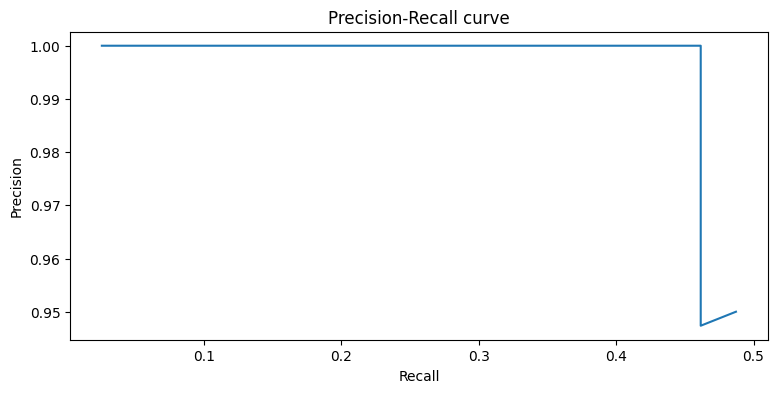

In [88]:
plt.figure(figsize=(9, 4))
plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
plt.title("Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [89]:
ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
print(f"AP50 = {ap50 :.4f}")

AP50 = 0.4602


### Unite all in one function

In [114]:
def compute_AP50(gt_path, predictions, image_path):
    '''

    :param gt_path: path to GT labels
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    with open(gt_path, "r") as f:
        boxes= f.readlines()
    #gt boxes are in the format x_c, y_c, width, height
    gt_boxes = [box.split(" ")[1:] for box in boxes]
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
    #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
    #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]

    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(len(results)))

    for i, result in enumerate(predictions):
        ious=[]
        if result['category_id']==0: #only person
            predicted_boxes.loc[i]['image'] = 'people_frames_1.jpg'
            predicted_boxes.loc[i]['confidence']=result['score']
            pr_box=result['bbox'].copy()
            pr_box=tlwh_tlbr(pr_box)
            for gt_box in gt_boxes:
                iou = intersection_over_union(gt_box, pr_box)
                ious.append(iou)
            if max(ious)>0.5:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['TP']=1
                predicted_boxes.loc[i]['FP']=0
            else:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['FP']=1
                predicted_boxes.loc[i]['TP']=0

    num_gt = len(gt_boxes)

    #compute precision and recall
    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt

    #plot predictions
    for result in predictions:
        pr_box=result['bbox'].copy()
        pr_box=tlwh_tlbr(pr_box)
        cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    print(f"AP50 = {ap50 :.4f}")



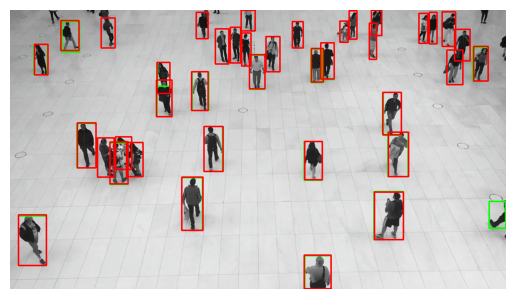

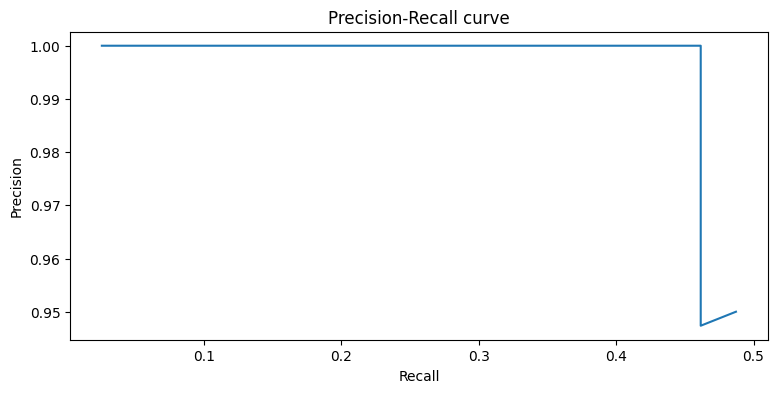

AP50 = 0.4602


In [115]:
compute_AP50("datasets/labels/people_frames_1.txt", results, "people_frames/people_frames_1.jpg")

In [93]:
image = cv2.imread("people_frames/people_frames_1.jpg")

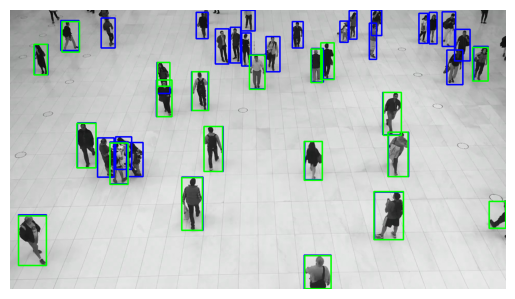

In [108]:
for result in results:
    pr_box=result['bbox'].copy()
    pr_box=tlwh_tlbr(pr_box)
    cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)
plt.imshow(image)
plt.axis('off')
plt.show()

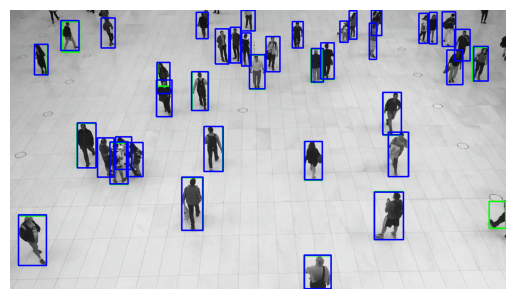

In [109]:
for box in gt_boxes:
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0, 0, 255), thickness=2)
plt.imshow(image)
plt.axis('off')
plt.show()

In [110]:
result.export_visuals(export_dir="demo_data/")
Image("demo_data/prediction_visual.png")

AttributeError: 'dict' object has no attribute 'export_visuals'

In [ ]:
image = cv2.imread("demo_data/prediction_visual.png")
cv2.imshow("image", image)

In [ ]:
result = get_sliced_prediction(
    "people_frames/people_frames_1.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

In [ ]:
results = result.to_coco_annotations()

In [ ]:
results

In [ ]:
result.export_visuals(export_dir="demo_data/")
Image("demo_data/prediction_visual.png")

In [ ]:
source_image_dir = "people_frames/"

In [ ]:
predict(
    model_type='yolov8',
    model_path=yolov8_model_path,
    model_device="cuda:1",
    model_confidence_threshold=0.4,
    source=source_image_dir,
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)